<img src="./../figures/title.svg"
       style="width:100%; height:auto; max-width:900px; padding:16px;">

Exploratory Data Analysis (EDA) starter notebook.

This notebook shows how to download, load and take a first look at the competition data.

In [5]:
import polars as pl

from cmi_kaggle_competition.config import RAW_DATA_DIR

train_df = pl.read_csv(
    RAW_DATA_DIR / "train.csv",
)

train_df.shape

2025-08-05 00:20:04.659 | INFO     | cmi_kaggle_competition.config:<module>:11 - PROJ_ROOT path is: /home/gaetan/projects/kaggle/cmi_kaggle_competition


(574945, 341)

In [6]:
train_df.head(5)

row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,…,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
str,str,str,i64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SEQ_000007_000000""","""Target""","""SEQ_000007""",0,"""SUBJ_059520""","""Seated Lean Non Dom - FACE DOW…","""Relaxes and moves hand to targ…","""Transition""","""Cheek - pinch skin""",6.683594,6.214844,3.355469,0.134399,-0.355164,-0.447327,-0.809753,28.943842,31.822186,29.553024,28.592863,28.310535,131.0,134.0,132.0,135.0,98.0,74.0,64.0,60.0,-1.0,-1.0,152.0,153.0,141.0,89.0,68.0,63.0,…,153.0,133.0,131.0,121.0,118.0,134.0,134.0,128.0,121.0,119.0,121.0,129.0,-1.0,113.0,124.0,122.0,131.0,-1.0,-1.0,-1.0,-1.0,120.0,127.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
"""SEQ_000007_000001""","""Target""","""SEQ_000007""",1,"""SUBJ_059520""","""Seated Lean Non Dom - FACE DOW…","""Relaxes and moves hand to targ…","""Transition""","""Cheek - pinch skin""",6.949219,6.214844,3.125,0.143494,-0.340271,-0.42865,-0.824524,29.340816,31.874645,29.79174,28.663383,28.406172,130.0,138.0,131.0,135.0,101.0,76.0,66.0,61.0,-1.0,-1.0,156.0,155.0,141.0,93.0,74.0,64.0,…,157.0,139.0,127.0,126.0,121.0,136.0,142.0,133.0,127.0,123.0,127.0,134.0,-1.0,116.0,122.0,123.0,126.0,-1.0,-1.0,-1.0,-1.0,122.0,129.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
"""SEQ_000007_000002""","""Target""","""SEQ_000007""",2,"""SUBJ_059520""","""Seated Lean Non Dom - FACE DOW…","""Relaxes and moves hand to targ…","""Transition""","""Cheek - pinch skin""",5.722656,5.410156,5.421875,0.219055,-0.274231,-0.356934,-0.865662,30.339359,30.935045,30.090014,28.796087,28.529778,137.0,136.0,147.0,109.0,90.0,81.0,74.0,74.0,-1.0,164.0,165.0,146.0,106.0,94.0,77.0,77.0,…,-1.0,-1.0,151.0,138.0,127.0,151.0,187.0,-1.0,156.0,136.0,135.0,134.0,-1.0,133.0,142.0,131.0,130.0,132.0,136.0,-1.0,-1.0,112.0,121.0,123.0,125.0,-1.0,-1.0,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
"""SEQ_000007_000003""","""Target""","""SEQ_000007""",3,"""SUBJ_059520""","""Seated Lean Non Dom - FACE DOW…","""Relaxes and moves hand to targ…","""Transition""","""Cheek - pinch skin""",6.6015625,3.53125,6.457031,0.297546,-0.26416,-0.238159,-0.885986,30.54373,27.044001,29.310717,29.018711,27.40201,143.0,147.0,170.0,127.0,109.0,98.0,95.0,95.0,-1.0,177.0,189.0,177.0,136.0,121.0,107.0,104.0,…,-1.0,149.0,142.0,135.0,-1.0,159.0,181.0,150.0,135.0,129.0,139.0,-1.0,-1.0,141.0,136.0,120.0,122.0,132.0,-1.0,-1.0,-1.0,107.0,112.0,115.0,140.0,-1.0,-1.0,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
"""SEQ_000007_000004""","""Target""","""SEQ_000007""",4,"""SUBJ_059520""","""Seated Lean Non Dom - FACE DOW…","""Relaxes and moves hand to targ…","""Transition""","""Cheek - pinch skin""",5.566406,0.277344,9.6328125,0.333557,-0.218628,-0.063538,-0.914856,29.317265,25.270855,26.808746,29.408604,27.357603,178.0,191.0,183.0,157.0,146.0,139.0,143.0,148.0,-1.0,-1.0,236.0,238.0,208.0,200.0,185.0,190.0,…,212.0,181.0,-1.0,-1.0,-1.0,184.0,-1.0,179.0,162.0,-1.0,-1.0,-1.0,-1.0,169.0,171.0,145.0,140.0,-1.0,-1.0,-1.0,-1.0,132.0,125.0,131.0,-1.0,-1.0,-1.0,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [7]:
train_df["gesture"].unique().to_list()

['Wave hello',
 'Forehead - scratch',
 'Text on phone',
 'Neck - scratch',
 'Eyelash - pull hair',
 'Glasses on/off',
 'Pull air toward your face',
 'Feel around in tray and pull out an object',
 'Write name in air',
 'Cheek - pinch skin',
 'Drink from bottle/cup',
 'Write name on leg',
 'Eyebrow - pull hair',
 'Above ear - pull hair',
 'Forehead - pull hairline',
 'Pinch knee/leg skin',
 'Neck - pinch skin',
 'Scratch knee/leg skin']

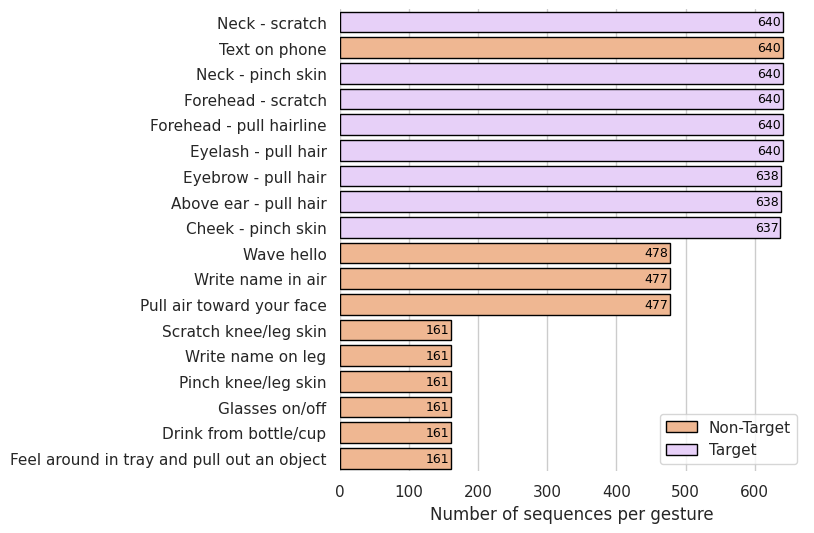

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

gesture_per_type = train_df["gesture", "sequence_type"].unique()

hist_gesture = gesture_per_type.join(
    train_df["gesture", "sequence_id"].unique()["gesture"].value_counts(),
    on="gesture",
    how="left",
).sort("count", descending=True)

sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

palette = {
    "Target": "#E8C9FF",
    "Non-Target": "#FFB482",
}

edge_palette = {
    "Target": "#9C52FF",  # violet foncé
    "Non-Target": "#B35400",  # orange foncé
}


hue_order = hist_gesture["sequence_type"].unique().sort()

barplot = sns.barplot(
    x="count",
    y="gesture",
    data=hist_gesture,
    palette=palette,
    hue="sequence_type",
    hue_order=hue_order,
    ax=ax,
    edgecolor="black",
)


for row in hist_gesture.iter_rows(named=True):
    ax.text(
        row["count"] - 20,
        row["gesture"],
        row["count"],
        color="black",
        ha="center",
        va="center",
        fontsize=9,
    )

# Add a legend and informative axis label
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Number of sequences per gesture")
sns.despine(left=True, bottom=True)

In [32]:
median_len_sequences_per_gesture = (
    train_df["gesture", "sequence_id", "sequence_type"]
    .group_by("sequence_id")
    .agg(
        pl.first("gesture"),
        pl.col("gesture").count().alias("count"),
        pl.first("sequence_type"),
    )
    .group_by("gesture")
    .agg(
        pl.first("sequence_type"),
        pl.col("count")
        .quantile(quantile=0.5, interpolation="higher")
        .alias("median_count")
        .cast(pl.Int64),
        pl.col("count").mean().alias("mean_count"),
    )
)

median_len_sequences_per_gesture

gesture,sequence_type,median_count,mean_count
str,str,i64,f64
"""Drink from bottle/cup""","""Non-Target""",69,81.322981
"""Text on phone""","""Non-Target""",75,91.346875
"""Wave hello""","""Non-Target""",60,71.874477
"""Pull air toward your face""","""Non-Target""",58,64.450734
"""Feel around in tray and pull o…","""Non-Target""",86,106.298137
…,…,…,…
"""Glasses on/off""","""Non-Target""",68,84.111801
"""Neck - scratch""","""Target""",62,88.467187
"""Neck - pinch skin""","""Target""",56,63.292187


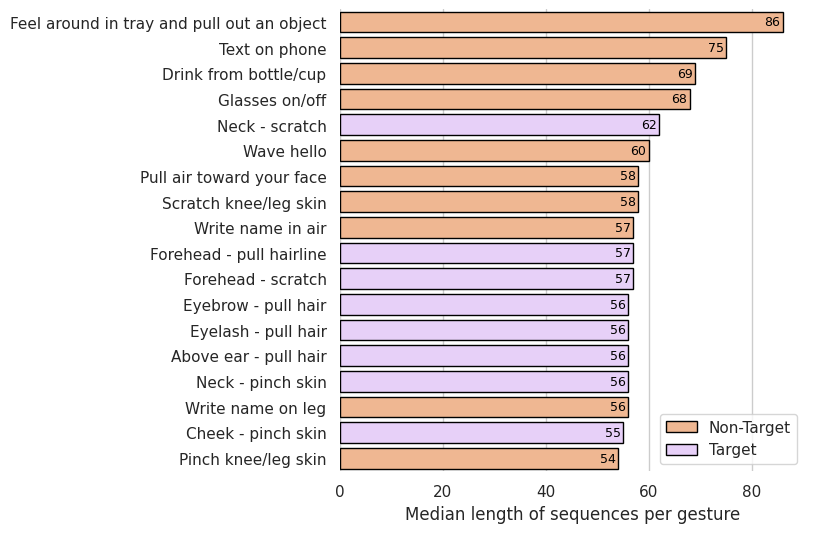

In [33]:
sorted_median_len_sequences_per_gesture = median_len_sequences_per_gesture.sort(
    "median_count", descending=True
)

sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

# Plot the total crashes
sns.barplot(
    x="median_count",
    y="gesture",
    data=sorted_median_len_sequences_per_gesture,
    palette=palette,
    hue="sequence_type",
    hue_order=sorted_median_len_sequences_per_gesture["sequence_type"].unique().sort(),
    edgecolor="black",
)


for row in sorted_median_len_sequences_per_gesture.iter_rows(named=True):
    ax.text(
        row["median_count"] - 2,
        row["gesture"],
        row["median_count"],
        color="black",
        ha="center",
        va="center",
        fontsize=9,
    )

# Add a legend and informative axis label
ax.legend(
    ncol=1,
    loc="lower right",
    frameon=True,
)
ax.set(ylabel="", xlabel="Median length of sequences per gesture")
sns.despine(left=True, bottom=True)

In [40]:
train_df

row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,…,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
str,str,str,i64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SEQ_000007_000000""","""Target""","""SEQ_000007""",0,"""SUBJ_059520""","""Seated Lean Non Dom - FACE DOW…","""Relaxes and moves hand to targ…","""Transition""","""Cheek - pinch skin""",6.683594,6.214844,3.355469,0.134399,-0.355164,-0.447327,-0.809753,28.943842,31.822186,29.553024,28.592863,28.310535,131.0,134.0,132.0,135.0,98.0,74.0,64.0,60.0,-1.0,-1.0,152.0,153.0,141.0,89.0,68.0,63.0,…,153.0,133.0,131.0,121.0,118.0,134.0,134.0,128.0,121.0,119.0,121.0,129.0,-1.0,113.0,124.0,122.0,131.0,-1.0,-1.0,-1.0,-1.0,120.0,127.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
"""SEQ_000007_000001""","""Target""","""SEQ_000007""",1,"""SUBJ_059520""","""Seated Lean Non Dom - FACE DOW…","""Relaxes and moves hand to targ…","""Transition""","""Cheek - pinch skin""",6.949219,6.214844,3.125,0.143494,-0.340271,-0.42865,-0.824524,29.340816,31.874645,29.79174,28.663383,28.406172,130.0,138.0,131.0,135.0,101.0,76.0,66.0,61.0,-1.0,-1.0,156.0,155.0,141.0,93.0,74.0,64.0,…,157.0,139.0,127.0,126.0,121.0,136.0,142.0,133.0,127.0,123.0,127.0,134.0,-1.0,116.0,122.0,123.0,126.0,-1.0,-1.0,-1.0,-1.0,122.0,129.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
"""SEQ_000007_000002""","""Target""","""SEQ_000007""",2,"""SUBJ_059520""","""Seated Lean Non Dom - FACE DOW…","""Relaxes and moves hand to targ…","""Transition""","""Cheek - pinch skin""",5.722656,5.410156,5.421875,0.219055,-0.274231,-0.356934,-0.865662,30.339359,30.935045,30.090014,28.796087,28.529778,137.0,136.0,147.0,109.0,90.0,81.0,74.0,74.0,-1.0,164.0,165.0,146.0,106.0,94.0,77.0,77.0,…,-1.0,-1.0,151.0,138.0,127.0,151.0,187.0,-1.0,156.0,136.0,135.0,134.0,-1.0,133.0,142.0,131.0,130.0,132.0,136.0,-1.0,-1.0,112.0,121.0,123.0,125.0,-1.0,-1.0,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
"""SEQ_000007_000003""","""Target""","""SEQ_000007""",3,"""SUBJ_059520""","""Seated Lean Non Dom - FACE DOW…","""Relaxes and moves hand to targ…","""Transition""","""Cheek - pinch skin""",6.6015625,3.53125,6.457031,0.297546,-0.26416,-0.238159,-0.885986,30.54373,27.044001,29.310717,29.018711,27.40201,143.0,147.0,170.0,127.0,109.0,98.0,95.0,95.0,-1.0,177.0,189.0,177.0,136.0,121.0,107.0,104.0,…,-1.0,149.0,142.0,135.0,-1.0,159.0,181.0,150.0,135.0,129.0,139.0,-1.0,-1.0,141.0,136.0,120.0,122.0,132.0,-1.0,-1.0,-1.0,107.0,112.0,115.0,140.0,-1.0,-1.0,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
"""SEQ_000007_000004""","""Target""","""SEQ_000007""",4,"""SUBJ_059520""","""Seated Lean Non Dom - FACE DOW…","""Relaxes and moves hand to targ…","""Transition""","""Cheek - pinch skin""",5.566406,0.277344,9.6328125,0.333557,-0.218628,-0.063538,-0.914856,29.317265,25.270855,26.808746,29.408604,27.357603,178.0,191.0,183.0,157.0,146.0,139.0,143.0,148.0,-1.0,-1.0,236.0,238.0,208.0,200.0,185.0,190.0,…,212.0,181.0,-1.0,-1.0,-1.0,184.0,-1.0,179.0,162.0,-1.0,-1.0,-1.0,-1.0,169.0,171.0,145.0,140.0,-1.0,-1.0,-1.0,-1.0,132.0,125.0,131.0,-1.0,-1.0,-1.0,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,

In [ ]:
rate_median_nan_value_per_gesture = (
    train_df["gesture", "sequence_id", "sequence_type"]
    .group_by("sequence_id")
    .agg(
        pl.first("gesture"),
        pl.col("gesture").null_count().alias("null_count"),
        pl.col("gesture").count().alias("count"),
        pl.first("sequence_type"),
    )
    .group_by("gesture")
    .agg(
        pl.first("sequence_type"),
        pl.col("null_count")
        .quantile(quantile=0.5, interpolation="higher")
        .alias("median_count")
        .cast(pl.Int64),
        pl.col("null_count").mean().alias("mean_count"),
    )
)

pl.Config.set_tbl_rows(50)

print(rate_median_nan_value_per_gesture)

pl.Config.restore_defaults()

shape: (18, 4)
┌─────────────────────────────────┬───────────────┬──────────────┬────────────┐
│ gesture                         ┆ sequence_type ┆ median_count ┆ mean_count │
│ ---                             ┆ ---           ┆ ---          ┆ ---        │
│ str                             ┆ str           ┆ i64          ┆ f64        │
╞═════════════════════════════════╪═══════════════╪══════════════╪════════════╡
│ Drink from bottle/cup           ┆ Non-Target    ┆ 0            ┆ 0.0        │
│ Glasses on/off                  ┆ Non-Target    ┆ 0            ┆ 0.0        │
│ Feel around in tray and pull o… ┆ Non-Target    ┆ 0            ┆ 0.0        │
│ Write name on leg               ┆ Non-Target    ┆ 0            ┆ 0.0        │
│ Forehead - scratch              ┆ Target        ┆ 0            ┆ 0.0        │
│ Eyebrow - pull hair             ┆ Target        ┆ 0            ┆ 0.0        │
│ Cheek - pinch skin              ┆ Target        ┆ 0            ┆ 0.0        │
│ Above ear - pull hair  

polars.config.Config